## L_0 Deep_CCA Refinment And Expriments:

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
import torch
import numpy as np
import tqdm
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **StochasticGates**
The `StochasticGates` class implements a probabilistic gating mechanism to enforce sparsity in feature selection. It extends `torch.nn.Module` and learns a set of gating parameters, `\(\mu\)`, which determine the importance of each input feature. The gating mechanism follows:

$$
z = \text{clamp}(\mu + \sigma \cdot \mathcal{N}(0,1), 0, 1)
$$

where:
- $\mu$ is a learnable parameter initialized as ones or a provided value.
- $\sigma $ controls the noise level, enabling stochastic feature selection.

The forward pass applies element-wise gating:

$$
x' = x \odot z
$$

where $\odot$ denotes the Hadamard product.

Additional methods include:
- **`get_reg()`**: Computes the regularization term:

$$
\lambda \sum \frac{1 + \text{erf}(\frac{\mu}{\sigma \sqrt{2}})}{2}
$$

which promotes sparsity.
- **`get_gates()`**: Returns clamped gate values $\mu$ .
- **`get_eta_estimate()`**: Provides an estimate of expected gate activation probability:

$$
\frac{1 + \text{erf}(\frac{\mu}{\sigma \sqrt{2}})}{2}
$$

This gating mechanism ensures that only the most relevant features contribute to the final representation while maintaining differentiability for optimization.

In [ ]:

class StochasticGates(nn.Module):
    def __init__(self, size, sigma, lam, gate_init=None):
        super().__init__()
        self.size = size
        if gate_init is None:
            mus = 1.0 * torch.ones(size)
        else:
            mus = torch.from_numpy(gate_init)
        self.mus = nn.Parameter(mus, requires_grad=True)
        self.sigma = sigma
        self.lam = lam

    def forward(self, x):
        gaussian = self.sigma * torch.randn(self.mus.size()) * self.training
        shifted_gaussian = self.mus + gaussian.to(x.device)
        z = torch.clamp(shifted_gaussian, 0.0, 1.0)
        new_x = x * z
        return new_x

    def get_reg(self):
        return self.lam * torch.sum((1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2)

    def get_gates(self):
        return torch.clamp(self.mus, 0.0, 1.0)

    def get_eta_estimate(self):
            """
            Returns the gating probabilities (i.e., 'z' in [0,1]).
            Note: This is *not* the final canonical vector if you have
            additional learned weights to multiply by, or if you need L2 norm.
            """
            eta = (1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2
            return eta



### **SDCCA CLASS**

The `SDCCA` class implements Sparse Deep Canonical Correlation Analysis (SDCCA) with stochastic gating to enforce sparsity in feature selection. It extends `torch.nn.Module` and consists of two gated transformation pipelines for input modalities `X` and `Y`. Each pipeline includes:
1. `StochasticGates` for probabilistic feature selection.
2. A transformation function (`f` for `X`, `g` for `Y`).

The `forward` method applies these transformations to the inputs, returning sparse representations of `X` and `Y`. This structure ensures efficient feature selection and enhances model interpretability.
*italicized text*

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class SDCCA(nn.Module):
    def __init__(self, x_size, f, lamx, sigmax,
                       y_size, g, lamy, sigmay):
        super().__init__()
        self.gated_f = nn.Sequential(
            StochasticGates(x_size, sigmax, lamx),
            f)
        self.gated_g = nn.Sequential(
            StochasticGates(y_size, sigmay, lamy),
            g)

    def forward(self, X, Y):
        return self.gated_f(X), self.gated_g(Y)

    def get_reg(self):
        # Regularization from both gate modules
        return self.gated_f[0].get_reg().mean() + self.gated_g[0].get_reg().mean()

    def get_gates(self):
        # Retrieve current gate values from both modalities
        return self.gated_f[0].get_gates(), self.gated_g[0].get_gates()

    def get_function_parameters(self):
        # Return learnable parameters of the function parts f and g.
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[1].parameters())
        return params

    def get_gates_parameters(self):
        # Return learnable parameters of the stochastic gates.
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[0].parameters())
        return params

    def get_eta_estimate(self):
        # Retrieve estimated eta values for each modality.
        eta_x = self.gated_f[0].get_eta_estimate()
        eta_y = self.gated_g[0].get_eta_estimate()
        return eta_x, eta_y

    def plot_gradients(self):
        """
        Plots histograms of the gradient norms for gate parameters and function parameters.
        Call this method after loss.backward() and before the optimizer steps.
        """
        # Collect gradient norms for gate parameters.
        gate_grads = []
        for param in self.get_gates_parameters():
            if param.grad is not None:
                grad_norm = param.grad.detach().cpu().norm().item()
                gate_grads.append(grad_norm)

        # Collect gradient norms for function parameters.
        func_grads = []
        for param in self.get_function_parameters():
            if param.grad is not None:
                grad_norm = param.grad.detach().cpu().norm().item()
                func_grads.append(grad_norm)

        avg_gate_grad = np.mean(gate_grads) if gate_grads else 0
        avg_func_grad = np.mean(func_grads) if func_grads else 0

        print(f"Avg Gate Gradients: {avg_gate_grad:.4f}, Avg Function Gradients: {avg_func_grad:.4f}")



### **Utilities Tools**
### Overview

This module provides essential functions for generating synthetic data, normalizing tensors, visualizing gating mechanisms, and computing estimation errors in Sparse Canonical Correlation Analysis (SCCA).

### Data Generation (`gen_data`)

The function `gen_data` generates synthetic paired datasets $(X, Y)$ with a predefined correlation structure. It constructs covariance matrices $\Sigma_x$ and $\Sigma_y$, which can follow different structures:

- **Identity covariance**: $\Sigma_x = I_p$, $\Sigma_y = I_q$
- **Toeplitz covariance**: $\Sigma_x[i, j] = 0.9^{|i - j|}$
- **Sparse inverse covariance**: Uses a structured inverse covariance matrix $\Sigma_0$

The generated data follows a multivariate normal distribution:

$$
(X, Y) \sim \mathcal{N} \left( 0, \Sigma \right)
$$

where $\Sigma$ is the block covariance matrix:

$$
\Sigma =
\begin{bmatrix}
\Sigma_x & \Sigma_{xy} \\
\Sigma_{yx} & \Sigma_y
\end{bmatrix}
$$

The cross-covariance matrix $\Sigma_{xy}$ is constructed as:

$$
\Sigma_{xy} = \rho \cdot \Sigma_x \cdot u v^T \cdot \Sigma_y
$$

where:
- $\rho$ controls the correlation strength,
- $u$ and $v$ are sparse canonical vectors with $k$ nonzero entries,
- $\Sigma_{yx} = \Sigma_{xy}^T$ ensures symmetry.

The function ensures positive definiteness of $\Sigma$ before drawing samples from $\mathcal{N}(0, \Sigma)$.

### L2 Normalization (`L2Norm`)

This class normalizes input tensors along the last dimension:

$$
x' = \frac{x}{\|x\|}
$$

ensuring unit-norm feature vectors.

### Gate Visualization (`plot_gates`)

The function `plot_gates` visualizes learned gating values alongside ground truth canonical vectors. It plots:
- $x$-gates (compared to true canonical vector $u$)
- $y$-gates (compared to true canonical vector $v$)

This helps assess whether the model selects relevant features.

### Canonical Estimation Error (`canonical_error`)

This function computes the estimation error between a true and estimated canonical vector:

$$
\text{error} = 2 \left( 1 - \left| \phi_{\text{true}}^T \phi_{\text{est}} \right| \right)
$$

which measures the deviation in alignment between estimated and true canonical directions.

### Estimation Error Computation (`compute_estimation_errors`)

This function evaluates errors for both canonical vectors:

$$
\text{error}_\phi = \text{canonical\_error}(\phi_{\text{true}}, \phi_{\text{est}})
$$

$$
\text{error}_\eta = \text{canonical\_error}(\eta_{\text{true}}, \eta_{\text{est}})
$$

It returns the estimation errors for further analysis.

---

This module plays a crucial role in generating synthetic data, normalizing representations, evaluating gate performance, and quantifying estimation accuracy.


In [ ]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


def gen_data(n=400, p=1600, q=1600, rho=0.9, flag=0, fac=1):
    np.random.seed(123)
    Sigma_x = 1 * np.eye(p)
    Sigma_y = 1 * np.eye(q)
    Sigma_0 = 1 * np.eye(p)
    if flag == 1:
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = 0.9 ** (abs(i - j))
    elif flag == 2:
        for i in range(p):
            for j in range(p):
                if np.abs(i - j) == 1:
                    Sigma_0[i, j] = 0.5
                elif np.abs(i - j) == 2:
                    Sigma_0[i, j] = 0.4
        Sigma_1 = np.copy(np.linalg.inv(Sigma_0))
        Sigma_x = np.copy(Sigma_1)
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = Sigma_1[i, j] / (np.sqrt(Sigma_1[i, i] * Sigma_1[j, j]))

    Sigma_y = Sigma_x

    k = 5
    not_valid = True
    while not_valid:
        u = np.zeros((p, 1))
        v = np.zeros((q, 1))
        ind1 = np.random.choice(np.arange(p), k)
        ind2 = np.random.choice(np.arange(q), k)
        u[ind1] = fac / np.sqrt(k)
        v[ind2] = fac / np.sqrt(k)
        Sigma_xy = rho * Sigma_x @ u @ v.T @ Sigma_y
        Sigma1 = np.hstack((Sigma_x, Sigma_xy))
        Sigma2 = np.hstack((Sigma_xy.T, Sigma_y))
        Sigma = np.vstack((Sigma1, Sigma2))
        #    pos_def=is_pos_def(Sigma)
        #   if pos_def:
        not_valid = False
        if sum(u != 0) != k or sum(v != 0) != k:
            print('problems with u or v')
            not_valid = True
        try:
            xy = np.random.multivariate_normal(np.zeros(Sigma.shape[0]), Sigma, n, check_valid='raise')
        except:
            print('Cov not valid')
            not_valid = True

    x = xy[:, :p]
    y = xy[:, p:]
    return x, y, u, v, Sigma_xy


class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm, self).__init__()

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1)


def plot_gates(net, name, u, v):
    g_x, g_y = net.get_gates()

    #print("Raw gate values for x:", g_x)
    #print("Raw gate values for y:", g_y)

    g_x = g_x.cpu().detach().numpy().T
    g_y = g_y.cpu().detach().numpy().T

    plt.subplot(2, 1, 1)
    plt.stem(u, basefmt=" ", markerfmt='D')
    plt.stem(g_x, basefmt=" ", linefmt='r')
    plt.title(f'x gates')

    plt.subplot(2, 1, 2)
    plt.stem(v, basefmt=" ", markerfmt='D')
    plt.stem(g_y, basefmt=" ", linefmt='r')
    plt.title(f'y gates')

    plt.suptitle(f'{name}')
    plt.show()
    plt.close()

def canonical_error(true_vec, est_vec):
    """
    Computes the canonical estimation error metric as used in the paper.

    Parameters:
        true_vec (np.ndarray): Ground truth canonical vector.
        est_vec (np.ndarray): Estimated canonical vector.

    Returns:
        float: Estimation error.
    """
    return 2 * (1 - np.abs(np.dot(true_vec.T, est_vec)))


def compute_estimation_errors(true_phi, est_phi, true_eta, est_eta):
    """
    Computes the estimation errors for the canonical vectors of both views.

    Parameters:
        true_phi (np.ndarray): Ground truth canonical vector for view X.
        est_phi (np.ndarray): Estimated canonical vector for view X.
        true_eta (np.ndarray): Ground truth canonical vector for view Y.
        est_eta (np.ndarray): Estimated canonical vector for view Y.

    Returns:
        tuple: (error_phi, error_eta) corresponding to each view.
    """
    error_phi = canonical_error(true_phi, est_phi)
    error_eta = canonical_error(true_eta, est_eta)

    return error_phi, error_eta

### Main

The `main()` function initializes and trains a Sparse Canonical Correlation Analysis (SCCA) model using stochastic gating. It generates synthetic data, optimizes the gating and transformation functions, and evaluates estimation errors.

### Model Architecture

### Overview

This module defines functions for creating and training a **Sparse Deep Canonical Correlation Analysis (SDCCA)** model. It includes:
- **`create_networks()`**: Constructs the SDCCA model with neural network transformations.
- **`train()`**: Optimizes the model using two separate optimizers for function parameters and gating parameters.
- **`simple_train()`**: A simplified training routine using a single optimizer.

---

### Model Creation (`create_networks`)

The function `create_networks()` initializes the SDCCA model with two neural networks, $f$ and $g$, each applied to one of the input modalities ($X$ and $Y$). The architecture consists of:
- **Three fully connected layers**:
  - Input dimension: `size`
  - Hidden layers: 100 neurons each with ReLU activation
  - Output dimension: 10 (final embedding space)
- **L2 Normalization**: Ensures output vectors have unit norm.

The SDCCA model is created with:
$$
\text{net} = \text{SDCCA}(\text{size}, f, \lambda_x, \sigma_x, \text{size}, g, \lambda_y, \sigma_y)
$$
where $\lambda_x, \lambda_y$ control sparsity and $\sigma_x, \sigma_y$ define gating noise levels.

---

### Training Function (`train`)

The function `train()` optimizes both **gating parameters** and **function parameters** using separate optimizers:
1. **Gating parameters** (`gates_optim`): Updated every $K$ steps.
2. **Function parameters** (`func_optim`): Updated at every iteration.

#### Training Steps:
1. **Forward Pass**: Compute embeddings $x_{\text{emb}}$ and $y_{\text{emb}}$:
   $$
   x_{\text{emb}}, y_{\text{emb}} = \text{net}(x, y)
   $$
2. **Compute Loss**:
   - **Negative Correlation Loss**: Measures alignment between projected embeddings.
   - **Regularization Term**: Enforces sparsity.
   $$
   \text{loss} = \text{neg\_corr} + \text{reg}
   $$
3. **Backward Pass**:
   - Compute gradients and update function parameters.
   - Update gating parameters only if $k = 0$.

This ensures efficient optimization while maintaining sparsity control.

---

### Simplified Training Function (`simple_train`)

The function `simple_train()` performs the same training steps as `train()` but uses a **single optimizer** for both functions and gates. This variant is useful when fine-grained control over optimization is not required.

---

### Summary

- `create_networks()` constructs a **deep neural SDCCA model** with separate transformations for each modality.
- `train()` implements a **two-optimizer training scheme**, balancing function learning and feature selection.
- `simple_train()` provides a **basic training alternative** using a single optimizer.

This setup enables efficient training of SDCCA models with **structured sparsity and feature selection**.


In [ ]:
def create_networks(lamx, sigmax, lamy, sigmay, size,hidden_layer_sizes):

    # Helper function to build a Sequential network
    def build_network(input_size, layer_sizes):
        layers = []
        prev_size = input_size

        for hidden_size in layer_sizes:
            layers.append(nn.Linear(prev_size, hidden_size, bias=False))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        # Remove last ReLU for the final hidden layer
        layers = layers[:-1]
        layers.append(L2Norm())

        return nn.Sequential(*layers)

    # Create networks f and g with customizable layers
    f = build_network(size, hidden_layer_sizes)
    g = build_network(size, hidden_layer_sizes)

    net = SDCCA(size, f, lamx, sigmax,
                size, g, lamy, sigmay)

    return net


def train(net, criterion, x, y, gates_optim, func_optim, k):
    net.train()
    if k == 0:
        gates_optim.zero_grad()
    func_optim.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    # Optionally, call the gradient plotting method here for debugging:
    # net.plot_gradients()

    func_optim.step()
    if k == 0:
        gates_optim.step()

    return neg_corr.item(), reg.item()


def simple_train(net, criterion, x, y, optimizer):
    net.train()
    optimizer.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    optimizer.step()


In [ ]:
import numpy as np
import torch

def init_gate_params_from_crosscov(
    X: np.ndarray,
    Y: np.ndarray,
    percentile_cov: float = 90.0,
    percentile_vec: float = 90.0
):
    # 1) Compute cross-covariance
    N, Dx = X.shape
    _, Dy = Y.shape
    C_xy = (X.T @ Y) / (N - 1)

    # 2) Threshold the cross-cov
    abs_cxy = np.abs(C_xy).flatten()
    cutoff_cov = np.percentile(abs_cxy, percentile_cov)
    C_bar = np.where(np.abs(C_xy) > cutoff_cov, C_xy, 0.0)

    # 3) SVD on thresholded matrix
    U, S, Vt = np.linalg.svd(C_bar, full_matrices=False)
    u = U[:, 0]   # shape (Dx,)
    v = Vt[0, :]  # shape (Dy,)

    # 4) Threshold the absolute values of u, v
    abs_u = np.abs(u)
    abs_v = np.abs(v)
    cutoff_u = np.percentile(abs_u, percentile_vec)
    cutoff_v = np.percentile(abs_v, percentile_vec)
    abs_u[abs_u < cutoff_u] = 0.0
    abs_v[abs_v < cutoff_v] = 0.0

    # 5) Construct mu_x, mu_y
    mu_x = 0.5 + abs_u
    mu_y = 0.5 + abs_v
    mu_x = np.clip(mu_x, 0.0, 1.0)
    mu_y = np.clip(mu_y, 0.0, 1.0)

    return mu_x, mu_y


## Loss Function

### Summary

This module provides two essential components for **Sparse Canonical Correlation Analysis (SCCA)**:

1. **Covariance Computation (`cov`)**  
   - Computes the sample covariance between two datasets.
   - Formula:
     $$
     \text{cov}(X, Y) = \frac{(Y - \bar{Y})^T (X - \bar{X})}{N - 1}
     $$
   - Ensures proper statistical estimation of relationships between two feature sets.

2. **Negative Correlation Loss (`NegCorr`)**  
   - Implements a loss function to **maximize canonical correlation**.
   - Computes covariance matrices:
     - $C_{yy} = \text{cov}(Y, Y)$
     - $C_{yx} = \text{cov}(Y, X)$
     - $C_{xx} = \text{cov}(X, X)$
   - Regularizes diagonal elements to avoid singularity:
     $$
     C_{yy} = C_{yy} + \epsilon I, \quad C_{xx} = C_{xx} + \epsilon I
     $$
   - Computes the **correlation matrix**:
     $$
     M = C_{yy}^{-1} C_{yx} C_{xx}^{-1} C_{yx}^T
     $$
   - Returns the **negative trace** of $M$ as the loss:
     $$
    L = -\text{Tr}M
     $$

### Key Takeaways
- **`cov()`** provides an efficient way to compute empirical covariance.
- **`NegCorr`** ensures that learned feature representations are **highly correlated**.
- **Regularization** prevents numerical instability when inverting covariance matrices.

This loss function is fundamental in **SCCA models**, ensuring that feature embeddings capture **maximally correlated** information across different modalities.


In [ ]:
def cov(x, y):
    x_bar = x - x.mean(axis=0)
    y_bar = y - y.mean(axis=0)
    N = x_bar.shape[0]
    return (y_bar.T @ x_bar).T / (N - 1)


class NegCorr(nn.Module):
    def __init__(self, device, eps=1e-5):
        super(NegCorr, self).__init__()
        self.device = device
        self.eps = eps

    def forward(self, x, y):
        C_yy = cov(y, y)
        C_yx = cov(y, x)
        C_xx = cov(x, x)

        C_yy = C_yy + torch.eye(C_yy.shape[0], device=self.device) * self.eps
        C_xx = C_xx + torch.eye(C_xx.shape[0], device=self.device) * self.eps

        M = torch.linalg.multi_dot([torch.inverse(C_yy),
                                    C_yx,
                                    torch.inverse(C_xx),
                                    C_yx.T])
        return -torch.trace(M)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Standard libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup for clear visuals
sns.set(style='whitegrid', palette='muted')


# Load dataset
# Replace 'path/to/your/file.tsv' with the actual path
# to the 'brca_metabric_clinical_data.tsv' file
data = pd.read_csv('/content/drive/MyDrive/brca_metabric_clinical_data.tsv', sep='\t')

# Inspecting the first few entries
data.head()

Mounted at /content/drive


,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,140.500000,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,84.633333,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,153.300000,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,164.933333,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.800000,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


Dataset Shape: (2509, 39)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2509 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Number of Samples Per Patient,TMB (nonsynonymous),Tumor Size,Tumor Stage
count,2498.000000,2498.000000,2388.000000,2243.000000,2358.000000,2287.000000,1981.000000,2388.000000,2509.0,2509.000000,2360.000000,1788.000000
mean,60.420300,2.900320,2.412060,1.950513,5.590755,4.028787,125.244271,110.293649,1.0,6.849746,26.220093,1.713647
std,13.032997,1.962216,0.649363,4.017774,3.989171,1.189092,76.111772,77.539698,0.0,5.320394,15.370883,0.655307
min,21.930000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000
25%,50.920000,1.000000,2.000000,0.000000,3.000000,3.048000,60.866667,41.100000,1.0,3.922553,17.000000,1.000000
50%,61.110000,3.000000,3.000000,0.000000,5.000000,4.044000,116.466667,100.416667,1.0,6.537589,22.410000,2.000000
75%,70.000000,4.000000,3.000000,2.000000,7.000000,5.040000,185.133333,169.875000,1.0,9.152624,30.000000,2.000000
max,96.290000,9.000000,3.000000,45.000000,81.000000,7.200000,355.200000,389.333333,1.0,104.601416,182.000000,4.000000



Missing Value Summary:


,0
3-Gene classifier subtype,745
Tumor Stage,721
Primary Tumor Laterality,639
Cellularity,592
Type of Breast Surgery,554
HER2 status measured by SNP6,529
Hormone Therapy,529
PR Status,529
Radio Therapy,529
Inferred Menopausal State,529


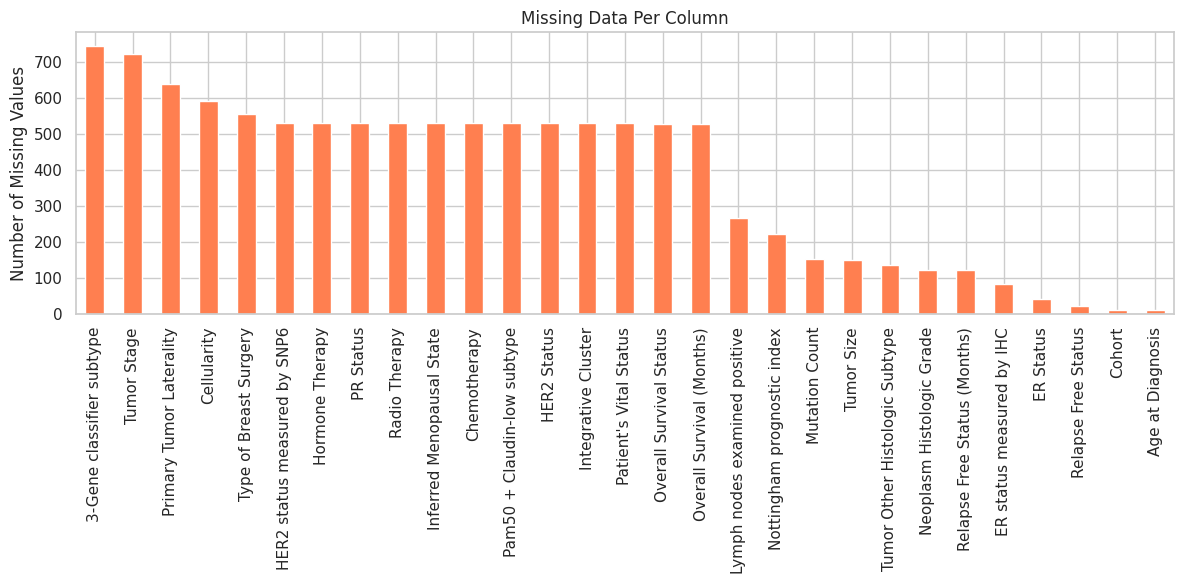

In [ ]:
# === Dataset Shape ===
print("Dataset Shape:", data.shape)

# === Column Types and Memory Usage ===
print("\nData Info:")
data.info()

# === Summary Statistics for Numeric Columns ===
print("\nSummary Statistics:")
display(data.describe())

# === Count Missing Values in Each Column ===
print("\nMissing Value Summary:")
missing_counts = data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
display(missing_counts)

# === Plot: Missing Data Bar Chart ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
missing_counts.plot(kind='bar', color='coral')
plt.title('Missing Data Per Column')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted')

# Step 1: Load RNA, CNA, and Clinical Data
# Update these paths based on your Google Drive location
rna_path = '/content/drive/MyDrive/brca_metabric/data_mrna_illumina_microarray.txt'
cna_path = '/content/drive/MyDrive/brca_metabric/data_cna.txt'
clinical_path = '/content/drive/MyDrive/brca_metabric_clinical_data.tsv'  # Use the correct file

# Load the data
rna = pd.read_csv(rna_path, sep='\t')
cna = pd.read_csv(cna_path, sep='\t')
clinical = pd.read_csv(clinical_path, sep='\t')

print("RNA Shape:", rna.shape)
print("CNA Shape:", cna.shape)
print("Clinical Shape:", clinical.shape)

# Step 2: Align Data by Sample IDs
# Check the column names in each dataset to confirm the ID column
print("\nRNA Columns (first 5):", rna.columns[:5])
print("CNA Columns (first 5):", cna.columns[:5])
print("Clinical Columns (first 5):", clinical.columns[:5])

# For RNA and CNA, the first few rows might be metadata; genes/features are columns
# Transpose to have samples as rows, genes as columns
# Drop 'Entrez_Gene_Id' if it exists and set 'Hugo_Symbol' as the column names
if 'Entrez_Gene_Id' in rna.columns:
    rna = rna.drop(columns=['Entrez_Gene_Id'])
rna = rna.set_index('Hugo_Symbol').T  # Transpose: samples as rows, genes as columns

if 'Entrez_Gene_Id' in cna.columns:
    cna = cna.drop(columns=['Entrez_Gene_Id'])
cna = cna.set_index('Hugo_Symbol').T  # Transpose: samples as rows, genes as columns

# Set index for clinical data using 'Sample ID' (correct for brca_metabric_clinical_data.tsv)
clinical = clinical.set_index('Sample ID')

# Align based on common sample IDs
common_ids = clinical.index.intersection(rna.index).intersection(cna.index)
rna = rna.loc[common_ids]
cna = cna.loc[common_ids]
clinical = clinical.loc[common_ids]

print("\nAfter Alignment:")
print("RNA Shape:", rna.shape)
print("CNA Shape:", rna.shape)
print("Clinical Shape:", clinical.shape)

# Step 3: Extract Labels for Evaluation
# Use 'Integrative Cluster' as the primary label
if 'Integrative Cluster' in clinical.columns:
    labels = clinical['Integrative Cluster'].dropna()
else:
    print("Integrative Cluster not found. Available columns:", clinical.columns)
    if 'Pam50 + Claudin-low subtype' in clinical.columns:
        labels = clinical['Pam50 + Claudin-low subtype'].dropna()  # Fallback label
    else:
        raise KeyError("Neither 'Integrative Cluster' nor 'Pam50 + Claudin-low subtype' found in clinical data.")

print("\nNumber of samples with labels:", len(labels))
print("Label Distribution:\n", labels.value_counts())

# Step 4: Handle Missing Values in RNA and CNA
# Drop columns (genes) with any missing values for simplicity
rna = rna.dropna(axis=1, how='any')
cna = cna.dropna(axis=1, how='any')

# Align again after dropping missing values
common_ids = clinical.index.intersection(rna.index).intersection(cna.index)
rna = rna.loc[common_ids]
cna = cna.loc[common_ids]
clinical = clinical.loc[common_ids]
labels = labels.loc[common_ids]

print("\nAfter Dropping Missing Values and Re-alignment:")
print("RNA Shape:", rna.shape)
print("CNA Shape:", cna.shape)
print("Clinical Shape:", clinical.shape)
print("Number of samples with labels after re-alignment:", len(labels))

# Step 5: Normalize Data
scaler = StandardScaler()
rna_scaled = scaler.fit_transform(rna)
cna_scaled = scaler.fit_transform(cna)

print("\nRNA scaled sample (first 5 rows, first 5 columns):")
print(rna_scaled[:5, :5])
print("CNA scaled sample (first 5 rows, first 5 columns):")
print(cna_scaled[:5, :5])

RNA Shape: (20603, 1982)
CNA Shape: (22544, 2175)
Clinical Shape: (2509, 39)

RNA Columns (first 5): Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'MB-0362', 'MB-0346', 'MB-0386'], dtype='object')
CNA Columns (first 5): Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'MB-0000', 'MB-0039', 'MB-0045'], dtype='object')
Clinical Columns (first 5): Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery'],
      dtype='object')

After Alignment:
RNA Shape: (1980, 20603)
CNA Shape: (1980, 20603)
Clinical Shape: (1980, 38)

Number of samples with labels: 1980
Label Distribution:
 Integrative Cluster
8       299
3       290
4ER+    260
10      226
5       190
7       190
9       146
1       139
6        85
4ER-     83
2        72
Name: count, dtype: int64

After Dropping Missing Values and Re-alignment:
RNA Shape: (1980, 20592)
CNA Shape: (1980, 22079)
Clinical Shape: (1980, 38)
Number of samples with labels after re-alignment: 1980

RNA scaled sample (first 5 rows, 

# CCA method testing

In [ ]:
from sklearn.cross_decomposition import CCA
import numpy as np

# Assume rna_scaled and cna_scaled are your normalized data (NumPy arrays)
cca = CCA(n_components=10)
X_c, Y_c = cca.fit_transform(rna_scaled, cna_scaled)
cca_embeddings = np.concatenate([X_c, Y_c], axis=1)  # Combined embeddings

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Apply k-means clustering to the CCA embeddings
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(cca_embeddings)

# Compute ARI (replace 'labels' with your actual labels variable)
ari = adjusted_rand_score(labels, clusters)
print(f"Clustering ARI for CCA: {ari:.4f}")

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Train SVM with cross-validation (replace 'labels' with your actual labels variable)
svm = SVC(random_state=42)
svm_accuracy = cross_val_score(svm, cca_embeddings, labels, cv=5).mean()
print(f"SVM Accuracy for CCA: {svm_accuracy:.4f}")

Clustering ARI for CCA: 0.0174
SVM Accuracy for CCA: 0.1949


# l0 deep CCA


In [ ]:
import torch
import torch.nn as nn

class TransformNet(nn.Module):
    def __init__(self, input_dim, output_dim=10):
        super(TransformNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 500), nn.Tanh(),
            nn.Linear(500, 300), nn.Tanh(),
            nn.Linear(300, 100), nn.Tanh(),
            nn.Linear(100, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Example dimensions (adjust based on your RNA and CNA data)
rna_features = 1000  # Number of RNA features
cna_features = 800   # Number of CNA features
embedding_dim = 10

f = TransformNet(rna_features, embedding_dim)
g = TransformNet(cna_features, embedding_dim)

In [ ]:
# Hyperparameters (tune these based on your data or the paper’s suggestions)
lamx = 0.02    # Regularization strength for RNA gates
lamy = 0.02    # Regularization strength for CNA gates
sigmax = 0.5   # Noise level for RNA gates
sigmay = 0.5   # Noise level for CNA gates

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize SDCCA
sdcca_model = SDCCA(
    x_size=rna_features, f=f, lamx=lamx, sigmax=sigmax,
    y_size=cna_features, g=g, lamy=lamy, sigmay=sigmay
).to(device)

In [ ]:
# Assuming NegCorr is defined as per your setup
class NegCorr(nn.Module):
    def __init__(self, device):
        super(NegCorr, self).__init__()
        self.device = device

    def forward(self, x, y):
        # Simplified negative correlation (implement as per paper)
        corr = torch.corrcoef(torch.cat((x.T, y.T), dim=0))[0, 1]
        return -corr

criterion = NegCorr(device)

# Optimizers
gates_optimizer = torch.optim.Adam(sdcca_model.get_gates_parameters(), lr=0.001)
funcs_optimizer = torch.optim.Adam(sdcca_model.get_function_parameters(), lr=0.001)
K = 8  # Update gates every K steps

In [ ]:
# Assume x (RNA) and y (CNA) are torch tensors on the device
# x: [n_samples, rna_features], y: [n_samples, cna_features]

def train(model, criterion, x, y, gates_opt, funcs_opt, update_gates):
    model.train()
    funcs_opt.zero_grad()
    if update_gates == 0:
        gates_opt.zero_grad()

    # Forward pass
    embedding_x, embedding_y = model(x, y)
    neg_corr = criterion(embedding_x, embedding_y)
    reg = model.get_reg()
    loss = neg_corr + reg

    # Backward pass
    loss.backward()
    funcs_opt.step()
    if update_gates == 0:
        gates_opt.step()

    return neg_corr.item(), reg.item()

# Training
for epoch in range(2000):
    neg_corr, reg = train(sdcca_model, criterion, x, y, gates_optimizer, funcs_optimizer, (epoch + 1) % K)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Neg Corr: {neg_corr:.4f}, Reg: {reg:.4f}")

NameError: name 'x' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

# Define StochasticGates class
class StochasticGates(nn.Module):
    def __init__(self, size, sigma, lam, gate_init=None):
        super().__init__()
        self.size = size
        if gate_init is None:
            mus = 1.0 * torch.ones(size)
        else:
            mus = torch.from_numpy(gate_init)
        self.mus = nn.Parameter(mus, requires_grad=True)
        self.sigma = sigma
        self.lam = lam

    def forward(self, x):
        gaussian = self.sigma * torch.randn(self.mus.size()) * self.training
        shifted_gaussian = self.mus + gaussian.to(x.device)
        z = torch.clamp(shifted_gaussian, 0.0, 1.0)
        new_x = x * z
        return new_x

    def get_reg(self):
        return self.lam * torch.sum((1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2)

    def get_gates(self):
        return torch.clamp(self.mus, 0.0, 1.0)

    def get_eta_estimate(self):
        eta = (1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2
        return eta

# Define SDCCA class
class SDCCA(nn.Module):
    def __init__(self, x_size, f, lamx, sigmax, y_size, g, lamy, sigmay):
        super().__init__()
        self.gated_f = nn.Sequential(
            StochasticGates(x_size, sigmax, lamx),
            f)
        self.gated_g = nn.Sequential(
            StochasticGates(y_size, sigmay, lamy),
            g)

    def forward(self, X, Y):
        return self.gated_f(X), self.gated_g(Y)

    def get_reg(self):
        return self.gated_f[0].get_reg().mean() + self.gated_g[0].get_reg().mean()

    def get_gates(self):
        return self.gated_f[0].get_gates(), self.gated_g[0].get_gates()

    def get_function_parameters(self):
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[1].parameters())
        return params

    def get_gates_parameters(self):
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[0].parameters())
        return params

# Define transformation network
class TransformNet(nn.Module):
    def __init__(self, input_dim, output_dim=10):
        super(TransformNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 500), nn.Tanh(),
            nn.Linear(500, 300), nn.Tanh(),
            nn.Linear(300, 100), nn.Tanh(),
            nn.Linear(100, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Define NegCorr (simplified for this example)
class NegCorr(nn.Module):
    def __init__(self, device, eps=1e-5):
        super(NegCorr, self).__init__()
        self.device = device
        self.eps = eps

    def forward(self, x, y):
        # Simplified correlation loss (replace with paper's implementation if needed)
        corr = torch.corrcoef(torch.cat((x, y), dim=1))[0, 1]
        return -corr

# Initialize model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(rna_scaled, dtype=torch.float32).to(device)
y = torch.tensor(cna_scaled, dtype=torch.float32).to(device)

f = TransformNet(rna_scaled.shape[1], output_dim=10)
g = TransformNet(cna_scaled.shape[1], output_dim=10)
sdcca_model = SDCCA(
    x_size=rna_scaled.shape[1], f=f, lamx=0.02, sigmax=1.0,
    y_size=cna_scaled.shape[1], g=g, lamy=0.02, sigmay=1.0
).to(device)

criterion = NegCorr(device)
gates_optimizer = torch.optim.Adam(sdcca_model.get_gates_parameters(), lr=0.5)
funcs_optimizer = torch.optim.Adam(sdcca_model.get_function_parameters(), lr=0.5)
K = 8

# Define train function
def train(model, criterion, x, y, gates_opt, funcs_opt, update_gates):
    model.train()
    funcs_opt.zero_grad()
    if update_gates == 0:
        gates_opt.zero_grad()

    embedding_x, embedding_y = model(x, y)
    neg_corr = criterion(embedding_x, embedding_y)
    reg = model.get_reg()
    loss = neg_corr + reg
    loss.backward()
    funcs_opt.step()
    if update_gates == 0:
        gates_opt.step()

    return neg_corr.item(), reg.item()

# Training loop
for epoch in range(2000):
    neg_corr, reg = train(sdcca_model, criterion, x, y, gates_optimizer, funcs_optimizer, (epoch + 1) % K)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Neg Corr: {neg_corr:.4f}, Reg: {reg:.4f}")

Epoch 0, Neg Corr: -0.3894, Reg: 718.0204
Epoch 100, Neg Corr: -0.9997, Reg: 0.0392
Epoch 200, Neg Corr: -0.9999, Reg: 0.0152
Epoch 300, Neg Corr: -0.9993, Reg: 0.0241
Epoch 400, Neg Corr: -1.0000, Reg: 0.0231
Epoch 500, Neg Corr: -0.9999, Reg: 0.0197
Epoch 600, Neg Corr: -1.0000, Reg: 0.0154
Epoch 700, Neg Corr: -1.0000, Reg: 0.0121
Epoch 800, Neg Corr: -1.0000, Reg: 0.0094
Epoch 900, Neg Corr: -1.0000, Reg: 0.0076
Epoch 1000, Neg Corr: -1.0000, Reg: 0.0061
Epoch 1100, Neg Corr: -1.0000, Reg: 0.0050
Epoch 1200, Neg Corr: -1.0000, Reg: 0.0041
Epoch 1300, Neg Corr: -1.0000, Reg: 0.0035
Epoch 1400, Neg Corr: -1.0000, Reg: 0.0030
Epoch 1500, Neg Corr: -1.0000, Reg: 0.0026
Epoch 1600, Neg Corr: -1.0000, Reg: 0.0022
Epoch 1700, Neg Corr: -1.0000, Reg: 0.0020
Epoch 1800, Neg Corr: -1.0000, Reg: 0.0017
Epoch 1900, Neg Corr: -1.0000, Reg: 0.0016


In [ ]:
sdcca_model.eval()
with torch.no_grad():
    embedding_x, embedding_y = sdcca_model(x, y)
    sdcca_embeddings = torch.cat((embedding_x, embedding_y), dim=1).cpu().numpy()

In [ ]:
from sklearn.decomposition import PCA

# Concatenate RNA and CNA data
concatenated_data = np.concatenate([rna_scaled, cna_scaled], axis=1)
pca = PCA(n_components=20)  # 20 components to match CCA's 20 dimensions (10 per view)
pca_embeddings = pca.fit_transform(concatenated_data)
raw_embeddings = concatenated_data

In [ ]:
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def compute_mi(embeddings, labels):
    # Discretize embeddings to compute MI
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    embeddings_discretized = discretizer.fit_transform(embeddings)
    # Compute MI between each dimension and labels, then average
    mi_scores = []
    for i in range(embeddings_discretized.shape[1]):
        mi = mutual_info_score(embeddings_discretized[:, i], labels)
        mi_scores.append(mi)
    return np.mean(mi_scores)

# Compute MI for each method
mi_cca = compute_mi(cca_embeddings, labels)
mi_sdcca = compute_mi(sdcca_embeddings, labels)
mi_pca = compute_mi(pca_embeddings, labels)
mi_raw = compute_mi(raw_embeddings, labels)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 2 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 3 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 4 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn

In [ ]:
# Clustering evaluation
kmeans_cca = KMeans(n_clusters=10, random_state=42)
cca_clusters = kmeans_cca.fit_predict(cca_embeddings)
cca_ari = adjusted_rand_score(labels, cca_clusters)

kmeans_sdcca = KMeans(n_clusters=10, random_state=42)
sdcca_clusters = kmeans_sdcca.fit_predict(sdcca_embeddings)
sdcca_ari = adjusted_rand_score(labels, sdcca_clusters)

kmeans_pca = KMeans(n_clusters=10, random_state=42)
pca_clusters = kmeans_pca.fit_predict(pca_embeddings)
pca_ari = adjusted_rand_score(labels, pca_clusters)

kmeans_raw = KMeans(n_clusters=10, random_state=42)
raw_clusters = kmeans_raw.fit_predict(raw_embeddings)
raw_ari = adjusted_rand_score(labels, raw_clusters)

# Classification evaluation
svm_cca = SVC(random_state=42)
cca_accuracy = cross_val_score(svm_cca, cca_embeddings, labels, cv=5).mean()

svm_sdcca = SVC(random_state=42)
sdcca_accuracy = cross_val_score(svm_sdcca, sdcca_embeddings, labels, cv=5).mean()

svm_pca = SVC(random_state=42)
pca_accuracy = cross_val_score(svm_pca, pca_embeddings, labels, cv=5).mean()

svm_raw = SVC(random_state=42)
raw_accuracy = cross_val_score(svm_raw, raw_embeddings, labels, cv=5).mean()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Compile results
results = {
    'Method': ['PCA', 'Raw Data', 'CCA', 'l0-DCCA'],
    'MI': [mi_pca, mi_raw, mi_cca, mi_sdcca],
    'KM (%)': [pca_ari * 100, raw_ari * 100, cca_ari * 100, sdcca_ari * 100],
    'SVM (%)': [pca_accuracy * 100, raw_accuracy * 100, cca_accuracy * 100, sdcca_accuracy * 100]
}

results_df = pd.DataFrame(results)
print("\nEvaluation Results:")
print(results_df.to_markdown(index=False))


Evaluation Results:
| Method   |        MI |   KM (%) |   SVM (%) |
|:---------|----------:|---------:|----------:|
| PCA      | 0.103796  | 21.5174  |   61.3636 |
| Raw Data | 0.0696218 | 21.7442  |   67.4747 |
| CCA      | 0.0252205 |  1.73562 |   19.4949 |
| l0-DCCA  | 0         |  0       |   15.101  |


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Placeholder for loading METABRIC data (replace with your actual data loading)
# Assuming RNA (X), CNA (Y), and labels are provided as numpy arrays
# Example: rna_data, cna_data, labels = load_metabric_data()
# For demonstration, we'll simulate loading preprocessed data
rna_data = np.random.rand(1000, 500)  # 1000 samples, 500 RNA features
cna_data = np.random.rand(1000, 200)  # 1000 samples, 200 CNA features
labels = np.random.randint(0, 10, 1000)  # 10 cancer subtypes

# Preprocess data (Step 1 assumed complete)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rna_data)  # RNA data
Y_scaled = scaler.fit_transform(cna_data)  # CNA data

# Split into training and tuning sets (80-20 split)
X_train, X_tune, Y_train, Y_tune, labels_train, labels_tune = train_test_split(
    X_scaled, Y_scaled, labels, test_size=0.2, random_state=42
)

# SCCA Functions from Simulation Example
def sweep(matrix, margin, stats, operation='/'):
    result_matrix = np.empty_like(matrix)
    if margin == 1:  # Column-wise
        for i in range(matrix.shape[1]):
            if operation == '/':
                result_matrix[:, i] = matrix[:, i] / stats[i]
            elif operation == '*':
                result_matrix[:, i] = matrix[:, i] * stats[i]
    elif margin == 0:  # Row-wise
        for i in range(matrix.shape[0]):
            if operation == '/':
                result_matrix[i, :] = matrix[i, :] / stats[i]
            elif operation == '*':
                result_matrix[i, :] = matrix[i, :] * stats[i]
    return result_matrix

def find_Omega(sigma_YX_hat, npairs, alpha=None, beta=None, y=None, x=None):
    n = y.shape[0]
    if npairs > 1:
        rho = alpha.T @ sigma_YX_hat @ beta
        omega = np.eye(n) - y @ alpha @ rho @ beta.T @ x.T / n
    else:
        omega = np.eye(n)
    return omega

def init0(sigma_YX_hat, sigma_X_hat, sigma_Y_hat, init_method, npairs, n):
    q, p = sigma_Y_hat.shape[1], sigma_X_hat.shape[1]
    if init_method == 'svd':
        u, _, v = np.linalg.svd(sigma_YX_hat, full_matrices=False)
        alpha_init = u[:, :npairs]
        beta_init = v.T[:, :npairs]
    elif init_method == 'random':
        alpha_init = np.random.normal(size=(q, npairs))
        beta_init = np.random.normal(size=(p, npairs))
    alpha_scale = np.diag(alpha_init.T @ sigma_Y_hat @ alpha_init)
    alpha_init = sweep(alpha_init, margin=1, stats=np.sqrt(alpha_scale), operation='/')
    beta_scale = np.diag(beta_init.T @ sigma_X_hat @ beta_init)
    beta_init = sweep(beta_init, margin=1, stats=np.sqrt(beta_scale), operation='/')
    return {'alpha_init': alpha_init, 'beta_init': beta_init}

def SCCA_solution(x, y, x_Omega, y_Omega, alpha0, beta0, standardize, lambda_alpha, lambda_beta, niter=100, eps=1e-4, column_index=0):
    n, q, p = x.shape[0], y.shape[1], x.shape[1]
    if alpha0.ndim > 1 and alpha0.shape[1] > 1:
        alpha0 = alpha0[:, column_index]
    if beta0.ndim > 1 and beta0.shape[1] > 1:
        beta0 = beta0[:, column_index]
    for i in range(niter):
        x0 = x_Omega @ beta0
        lasso_alpha = Lasso(alpha=lambda_alpha, fit_intercept=False)
        lasso_alpha.fit(y, x0)
        alpha1 = lasso_alpha.coef_
        if np.sum(np.abs(alpha1)) < eps:
            alpha0 = np.zeros(q)
            break
        alpha1_mask = np.abs(alpha1) > eps
        alpha1_scale = y[:, alpha1_mask] @ alpha1[alpha1_mask]
        alpha1 /= np.sqrt(alpha1_scale.T @ alpha1_scale / (n - 1))
        y0 = y_Omega @ alpha1
        lasso_beta = Lasso(alpha=lambda_beta, fit_intercept=False)
        lasso_beta.fit(x, y0)
        beta1 = lasso_beta.coef_
        if np.sum(np.abs(beta1)) < eps:
            beta0 = np.zeros(p)
            break
        beta1_scale = x[:, np.abs(beta1) > eps] @ beta1[np.abs(beta1) > eps]
        beta1 /= np.sqrt(beta1_scale.T @ beta1_scale / (n - 1))
        if np.sum(np.abs(alpha1 - alpha0)) < eps and np.sum(np.abs(beta1 - beta0)) < eps:
            break
        alpha0 = alpha1
        beta0 = beta1
    return {"alpha": alpha0, "beta": beta0, "niter": i+1}

def SCCA(x, y, lambda_alpha, lambda_beta, alpha_init=None, beta_init=None, niter=1000, npairs=1, init_method="svd", standardize=True, eps=1e-4):
    p, q, n = x.shape[1], y.shape[1], x.shape[0]
    x = StandardScaler().fit_transform(x) if standardize else x
    y = StandardScaler().fit_transform(y) if standardize else y
    sigma_YX_hat = np.cov(y.T, x.T)[:q, q:]
    sigma_X_hat = np.cov(x.T)
    sigma_Y_hat = np.cov(y.T)
    alpha = np.zeros((q, npairs))
    beta = np.zeros((p, npairs))
    if alpha_init is None:
        obj_init = init0(sigma_YX_hat, sigma_X_hat, sigma_Y_hat, init_method, npairs, n)
        alpha_init = obj_init['alpha_init']
        beta_init = obj_init['beta_init']
    for ipairs in range(npairs):
        omega = find_Omega(sigma_YX_hat, ipairs, alpha[:, :ipairs], beta[:, :ipairs], y, x)
        x_tmp = omega.dot(x)
        y_tmp = omega.T.dot(y)
        lambda_alpha0 = lambda_alpha if isinstance(lambda_alpha, float) else lambda_alpha[ipairs]
        lambda_beta0 = lambda_beta if isinstance(lambda_beta, float) else lambda_beta[ipairs]
        obj = SCCA_solution(x, y, x_tmp, y_tmp, alpha_init, beta_init, False, lambda_alpha0, lambda_beta0, niter, eps, ipairs)
        alpha[:, ipairs] = obj['alpha'].flatten()
        beta[:, ipairs] = obj['beta'].flatten()
    return {'alpha': alpha, 'beta': beta}

# Run SCCA with Hyperparameter Tuning
def run_scca_metabric(X_train, Y_train, X_tune, Y_tune, npairs=10):
    p, q = X_train.shape[1], Y_train.shape[1]
    lambdas = np.arange(1, 21) / 100  # Lambda range: 0.01 to 0.20
    rho_lambda = np.zeros(len(lambdas))
    for i_lambda, lambda_val in enumerate(lambdas):
        result = SCCA(X_train, Y_train, lambda_val, lambda_val, niter=100, npairs=npairs, init_method="svd")
        alpha_hat = result['alpha']
        beta_hat = result['beta']
        X_proj = X_tune @ beta_hat
        Y_proj = Y_tune @ alpha_hat
        corr_sum = sum(np.corrcoef(X_proj[:, k], Y_proj[:, k])[0, 1] ** 2 for k in range(npairs))
        rho_lambda[i_lambda] = corr_sum
    best_lambda = lambdas[np.argmax(rho_lambda)]
    final_result = SCCA(X_train, Y_train, best_lambda, best_lambda, niter=100, npairs=npairs, init_method="svd")
    train_embedding = np.hstack((X_train @ final_result['beta'], Y_train @ final_result['alpha']))
    tune_embedding = np.hstack((X_tune @ final_result['beta'], Y_tune @ final_result['alpha']))
    return train_embedding, tune_embedding

# Generate Embeddings
train_embedding, tune_embedding = run_scca_metabric(X_train, Y_train, X_tune, Y_tune)

# Evaluation Functions
def compute_mi(embeddings, labels):
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    embeddings_discretized = discretizer.fit_transform(embeddings)
    mi_scores = [mutual_info_score(embeddings_discretized[:, i], labels) for i in range(embeddings_discretized.shape[1])]
    return np.mean(mi_scores)

# Compute Metrics
mi_scca = compute_mi(train_embedding, labels_train)
kmeans_scca = KMeans(n_clusters=10, random_state=42)
scca_clusters = kmeans_scca.fit_predict(train_embedding)
scca_ari = adjusted_rand_score(labels_train, scca_clusters)
svm_scca = SVC(random_state=42)
scca_accuracy = cross_val_score(svm_scca, train_embedding, labels_train, cv=5).mean()

# Display Results
print("\nSCCA Evaluation Results:")
print(f"Mutual Information (MI): {mi_scca:.6f}")
print(f"Adjusted Rand Index (ARI, %): {scca_ari * 100:.2f}")
print(f"SVM Accuracy (%): {scca_accuracy * 100:.2f}")

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:292


SCCA Evaluation Results:
Mutual Information (MI): 0.050473
Adjusted Rand Index (ARI, %): -0.02
SVM Accuracy (%): 11.00


In [ ]:
# with torch.no_grad():
#     sdcca_model.eval()
#     embedding_x, embedding_y = sdcca_model(x, y)
#     embeddings = torch.cat((embedding_x, embedding_y), dim=1).cpu().numpy()

In [ ]:
# gates_x, gates_y = sdcca_model.get_gates()
# active_rna_features = (gates_x > 0.9).nonzero(as_tuple=True)[0]  # Threshold at 0.9
# active_cna_features = (gates_y > 0.9).nonzero(as_tuple=True)[0]
# print(f"Selected RNA features: {len(active_rna_features)}")
# print(f"Selected CNA features: {len(active_cna_features)}")

In [ ]:
# import optuna
# import torch
# import torch.optim as optim
# import numpy as np
# import os

# # If needed: from your_code import gen_data, create_networks, train, NegCorr

# def objective(trial):
#     """
#     Objective function for Optuna to optimize the final error of our l0-based CCA.
#     We unify lamx=lamy and sigmax=sigmay.
#     """
#     # ====== Hyperparameter Sampling (log-scale) ======
#     lam   = trial.suggest_float("lam",    5e-4,  100,   log=True)
#     sigma = trial.suggest_float("sigma",  1e-2,  0.5,   log=True)

#     # Learning rates for gates and function (still log-scale, wide range)
#     lr_gates = trial.suggest_float("lr_gates", 1e-5, 1e-1, log=True)
#     lr_func  = trial.suggest_float("lr_func",  1e-5, 1e-1, log=True)

#     # Frequency of gating vs function updates
#     K = trial.suggest_int("K", 1, 10)

#     # ====== Data Generation ======
#     samples = 400
#     size    = 800
#     x_data, y_data, u_true, v_true, _ = gen_data(samples, size, size)

#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     x = torch.tensor(x_data, device=device, dtype=torch.float32)
#     y = torch.tensor(y_data, device=device, dtype=torch.float32)

#     # ====== Create Network ======
#     net = create_networks(
#         lamx = lam,
#         lamy = lam,      # unify lamx and lamy
#         sigmax = sigma,
#         sigmay = sigma,  # unify sigmax and sigmay
#         size = size,
#         hidden_layer_sizes = [1600, 1600, 400]
#     ).to(device)

#     criterion = NegCorr(device)
#     gates_optimizer = optim.Adam(net.get_gates_parameters(), lr=lr_gates)
#     funcs_optimizer = optim.Adam(net.get_function_parameters(), lr=lr_func)

#     # We use fewer epochs here so each trial is faster
#     max_epochs = 10000
#     for epoch in range(max_epochs):
#         neg_corr, reg = train(
#             net,
#             criterion,
#             x,
#             y,
#             gates_optimizer,
#             funcs_optimizer,
#             (epoch + 1) % K
#         )
#         # Optionally: trial.report(...)
#         # if trial.should_prune():
#         #     raise optuna.TrialPruned()

#     # ====== Evaluate Final Error ======
#     eta_x_est, eta_y_est = net.get_eta_estimate()
#     eta_x_est = eta_x_est.detach().cpu().numpy().flatten()
#     eta_y_est = eta_y_est.detach().cpu().numpy().flatten()

#     # Normalize ground-truth
#     u_norm = u_true / (np.linalg.norm(u_true) + 1e-12)
#     v_norm = v_true / (np.linalg.norm(v_true) + 1e-12)

#     # Also normalize estimates to ensure dot products are in [-1,1]
#     eta_x_norm = eta_x_est / (np.linalg.norm(eta_x_est) + 1e-12)
#     eta_y_norm = eta_y_est / (np.linalg.norm(eta_y_est) + 1e-12)

#     dot_x = np.dot(u_norm.flatten(), eta_x_norm)
#     dot_y = np.dot(v_norm.flatten(), eta_y_norm)

#     # Nonnegative error in [0,2] for each view
#     error_x = 2.0 * (1.0 - abs(dot_x))
#     error_y = 2.0 * (1.0 - abs(dot_y))
#     final_error = (error_x + error_y) / 2.0

#     return final_error

# def run_optuna_search(n_trials=20):
#     """
#     Create (or load) an Optuna study from a SQLite file on Drive,
#     then run multiple trials to find hyperparams that minimize the final error.
#     """
#     # Example: Storing or reloading from 'my_study.db' on Google Drive
#     db_path = "/content/drive/MyDrive/my_study.db"
#     study_name = "my_l0_cca_study"

#     # Create or load if exists:
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=f"sqlite:///{db_path}",
#         load_if_exists=True,       # resume if it already exists
#         direction="minimize"
#     )

#     study.optimize(objective, n_trials=n_trials)

#     print("=== Study Summary ===")
#     print(f"Best value (lowest error): {study.best_value}")
#     print("Best hyperparams:")
#     for k, v in study.best_params.items():
#         print(f"  {k}: {v}")

#     return study

# #if __name__ == "__main__":
# #   study = run_optuna_search(n_trials=300)


=== Study Summary ===
Best value (lowest error): 1.8239748220432017
Best hyperparams:
  lam: 18.572825653334384
  sigma: 0.15282286895619035
  lr_gates: 0.07664367947558408
  lr_func: 0.01857446050496441
  K: 9

In [ ]:
# import torch
# import torch.optim as optim
# import numpy as np

# def final_run_chosen_params():
#     """
#     Single-run training with specific hyperparameters + gating plots every 1000 epochs.
#     """

#     # ========== 1) Hard-code your chosen hyperparams from trial #23 (example) ==========
#     lamx    = 72.07478917644063
#     lamy    = lamx  # or set lamy explicitly if desired
#     sigmax  = 0.3359306773255034
#     sigmay  = 0.16908335013155165
#     lr_gates= 0.004237579631381151
#     lr_func = 3.577682126914971e-05
#     K       = 2

#     # ========== 2) Generate data with samples=800, size=400 ==========
#     samples = 800
#     size    = 400
#     x_data, y_data, u, v, _ = gen_data(samples, size, size)

#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     x = torch.tensor(x_data, device=device, dtype=torch.float32)
#     y = torch.tensor(y_data, device=device, dtype=torch.float32)

#     # ========== 3) Build net with hidden layers [1600, 1600, 400] ==========
#     net = create_networks(
#         lamx=lamx, sigmax=sigmax,
#         lamy=lamy, sigmay=sigmay,
#         size=size,
#         hidden_layer_sizes=[1600, 1600, 400]  # per your request
#     ).to(device)

#     criterion = NegCorr(device)
#     gates_optimizer = optim.Adam(net.get_gates_parameters(), lr=lr_gates)
#     funcs_optimizer = optim.Adam(net.get_function_parameters(), lr=lr_func)

#     # ========== 4) Training loop with prints and gating plots ==========
#     epochs = 10000  # choose how many you like (1000, 5000, 50000, etc.)

#     for epoch in range(epochs):
#         neg_corr, reg = train(
#             net,
#             criterion,
#             x,
#             y,
#             gates_optimizer,
#             funcs_optimizer,
#             (epoch + 1) % K
#         )
#         # Print every 100 epochs
#         if (epoch + 1) % 100 == 0:
#             print(f"Epoch[{epoch+1}/{epochs}]: corr: {-neg_corr:.4f}, reg: {reg:.4f}")

#         # Plot gates every 1000 epochs
#         if (epoch + 1) % 1000 == 0:
#             # We assume you have a function 'plot_gates(net, epoch, u, v)' in your code
#             plot_gates(net, epoch + 1, u, v)

#     # ========== 5) Evaluate final result numerically ==========
#     eta_x_est, eta_y_est = net.get_eta_estimate()
#     eta_x_est = eta_x_est.detach().cpu().numpy().flatten()
#     eta_y_est = eta_y_est.detach().cpu().numpy().flatten()

#     # Compare to ground truth
#     u_norm = u / (np.linalg.norm(u) + 1e-12)
#     v_norm = v / (np.linalg.norm(v) + 1e-12)

#     # In your final evaluation
#     eta_x_est_norm = eta_x_est / (np.linalg.norm(eta_x_est) + 1e-12)
#     eta_y_est_norm = eta_y_est / (np.linalg.norm(eta_y_est) + 1e-12)

#     # Actually use the normalized estimates for the dot product:
#     dot_x = np.dot(u_norm, eta_x_est_norm)
#     dot_y = np.dot(v_norm, eta_y_est_norm)

#     error_x = 2.0 * (1.0 - abs(dot_x))
#     error_y = 2.0 * (1.0 - abs(dot_y))
#     final_error = (error_x + error_y) / 2.0


#     # Print summary
#     print("\n===== Final Results =====")
#     print(f"Correlation: {-neg_corr:.4f}")  # because neg_corr is negative correlation
#     print(f"dot_x={dot_x:.4f}, dot_y={dot_y:.4f}")
#     print(f"error_x={error_x:.4f}, error_y={error_y:.4f}, final_error={final_error:.4f}")

#     return final_error


# #if __name__ == "__main__":
# #    final_err = final_run_chosen_params()
# #    print(f"Single-run final error: {final_err:.4f}")
